In [13]:
import numpy as np
import scipy
import sys
import os

import pandas as pd

tokenlab_path=os.path.abspath("").replace('demo','src')
sys.path.insert(0,tokenlab_path)
#sys.path.append('/Users/stylianoskampakis/Dropbox (Personal)/Freelance/TokenLab/src/TokenLab/')

from TokenLab.simulationcomponents import *
from TokenLab.simulationcomponents.usergrowthclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.tokeneconomyclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.agentpoolclasses import *
from TokenLab.simulationcomponents.pricingclasses import *
from TokenLab.simulationcomponents.addons import AddOn_RandomNoise, AddOn_RandomNoiseProportional
from TokenLab.utils.helpers import *
from matplotlib import pyplot as plt

import mercury as mr
app = mr.App(title="TokenLab Demo - simple fee economy", description="Let us show you what TokenLab can do!") 



mercury.App

In [14]:
ITERATIONS=12*5
HOLDING_TIME=0.1
SUPPLY=10**9
INITIAL_PRICE=0.01

In [15]:
noise_param_value = mr.Slider(label="Noise", value=1, min=1, 
                              max=100,step=0.05)

holding_time_constant_value=mr.Slider(label="Holding time (days), min=0.01", value=1, min=1, 
                              max=365,step=0.05)

max_users_slider=mr.Slider(label="Active Monthly Users (at year 5)", value=500000, min=100000, 
                              max=5000000,step=10000)

supply_slider=mr.Slider(label="Supply (in millions)", value=100, min=10, 
                              max=10000,step=10)

transaction_fee_slider=mr.Slider(label="Transaction fee average (div by 100)", value=1, min=1, 
                              max=10000,step=1)

growth = mr.Select(label="Growth type", value="linear", choices=["linear", "logistic"])


mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Select

In [16]:
SUPPLY=supply_slider.value*(10**6)

In [17]:

mr.Markdown("""## Token Economy Simulation 🚀

This notebook simulates a simply token economy that is based only on transaction fees. This is used to demonstrate
TokenLab's capabilities.

TokenLab combines different elements of sochastic modelling with the purpose to simulate token price.

In this notebook we conduct 100 iterations of a 60-month long simulation of a token economy that is growing.
The simulation combines different elements such as the type of user growth (linear or logistic), the size of transactions,
the holding time and more.

The parameters are explored in more depth below. What is key to remember is that this is only a demonstration of
TokenLab's capabilities. TokenLab supports many different methods to simulate user growth, transactions, 
price estimation, and pretty much everything needed to simulate a tokenomics project!

Parameter details:

1) Holding time: The holding time is sampled from a half-normal with loc=scale.

2) The transaction fee slider determines the expected value of the average transaction. 
These are sampled from a half-normal distribution with location=scale.

3) The average number of transactions per user is sampled from a half-normal, with loc=0 and scale=0.5

4) The starting number of users is 100k.

5) Pricing equation uses the equation of exchange, with an anchoring effect which pushes the price 
down towards its older values. This is a more realistic assumption, as opposed to the real equation-of-exchange.

""")

## Token Economy Simulation 🚀

This notebook simulates a simply token economy that is based only on transaction fees. This is used to demonstrate
TokenLab's capabilities.

TokenLab combines different elements of sochastic modelling with the purpose to simulate token price.

In this notebook we conduct 100 iterations of a 60-month long simulation of a token economy that is growing.
The simulation combines different elements such as the type of user growth (linear or logistic), the size of transactions,
the holding time and more.

The parameters are explored in more depth below. What is key to remember is that this is only a demonstration of
TokenLab's capabilities. TokenLab supports many different methods to simulate user growth, transactions, 
price estimation, and pretty much everything needed to simulate a tokenomics project!

Parameter details:

1) Holding time: The holding time is sampled from a half-normal with loc=scale.

2) The transaction fee slider determines the expected value of the average transaction. 
These are sampled from a half-normal distribution with location=scale.

3) The average number of transactions per user is sampled from a half-normal, with loc=0 and scale=0.5

4) The starting number of users is 100k.

5) Pricing equation uses the equation of exchange, with an anchoring effect which pushes the price 
down towards its older values. This is a more realistic assumption, as opposed to the real equation-of-exchange.



In [18]:
random_noise=AddOn_RandomNoiseProportional(std_param=noise_param_value.value*0.1)

lr=lambda start,stop,num : logistic_saturated_space(start=start,stop=stop,num=num,steepness=4,takeoff=3)

if growth.value=='logistic':
    users=UserGrowth_Spaced(initial_users=100000,max_users=max_users_slider.value,num_steps=60,
                            space_function=lr,
                            noise_addon=random_noise
                           )
else:
    users=UserGrowth_Spaced(initial_users=100000,max_users=max_users_slider.value,num_steps=60,
                        noise_addon=random_noise
                       )


In [19]:
trans=transaction_fee_slider.value/10

In [20]:
transactions=TransactionManagement_Stochastic(value_distribution=scipy.stats.norm,
                                             value_dist_parameters={'loc':trans,'scale':trans},
                                              transactions_distribution=scipy.stats.halfnorm,
                                              transactions_dist_parameters={'loc':0,'scale':0.2},
                                              #transactions_constant=1,
                                              activity_probs=1,
                                             type_transaction='positive')



In [21]:
#plt.hist(scipy.stats.halfnorm.rvs(loc=1,scale=1,size=1000))

In [22]:
#plt.plot(users.get_users_store())

In [23]:
#holding_time=HoldingTime_Constant(holding_time_constant_value.value)
holding_time=HoldingTime_Stochastic(holding_time_params={'loc':holding_time_constant_value.value/30,
                                                         'scale':holding_time_constant_value.value/30})

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.48it/s]


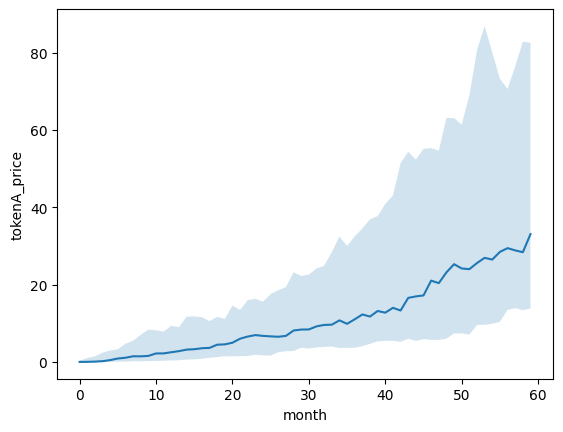

In [25]:


ap_fiat=AgentPool_Basic(users_controller=users,transactions_controller=transactions,currency='$')


te=TokenEconomy_Basic(holding_time=holding_time,supply=SUPPLY,token='tokenA',
                      initial_price=INITIAL_PRICE,burn_token=True,
                      price_function_parameters={'smoothing_param':0.1})
te.add_agent_pools([ap_fiat])

meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=100)
reps=meta.get_data()

_=meta.get_timeseries('tokenA_price',use_std=False)